<a href="https://colab.research.google.com/github/ISMRM-MIT-CMR/CMR-DL-challenge/blob/master/challenge_plug_and_play_sample_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Plug-and-Play Priors
Deep plug-and-play priors exploit the advantages of learning an advanced denoising scheme offline and plugging it into any optimization scheme to solve inverse problems, such as Magnetic Resonance Image Reconstruction.

## The CHALLENGE
The goal of this challenge is to find a way to reconstruct complex-valued MR images by using available denoisers. The plug-and-play prior challenge consists of two tasks:
1. Deploying a denoising model. If you plan to use available denoisers trained on real-valued images, you have to think about a way to apply them to the complex-valued images.
2. Definition of an optimization scheme. Inspiration can be found in the Suggested Reading section.

The code parts that have to be changed are marked with TODO.

The dataset `subject1.h5`, containing fully sampled k-space, can be used for quantitative and qualitative evaluation in the deployment phase. The results have to be generated for `subject2.h5`, which contains the undersampled k-space. The challenge will be evaluated quantitatively using the normalized root mean squared error (NRMSE), and based on the creativity and complexity to generate the solution.

We are looking forward to your creative submissions! Happy coding!

## The data
We provide two cardiac CINE datasets, with a single cardiac frame:
- `subject1.h5` contains the fully sampled k-space `kspace`, coil sensitivity maps `cmap`, and sampling masks at acceleration factors R=4 (`mask_R4`) and R=6 (`mask_R6`).
- `subject2.h5` is the _challenge_ subject and contains the undersampled k-space `kspace`, coil sensitivity maps `cmap` and the sampling mask `mask_R4`.

To process these datasets, we provide the basic framework for MRI reconstruction.

## Sample Solution
The aim of this challenge was to get familiar with pre-trained denoising networks and how they can be applied to complex-valued MRI reconstruction. This notebook contains a simple sample solution. There is not a single correct solution. :)

## Suggested readings
- S. V. Venkatakrishnan, C. A. Bouman and B. Wohlberg. [Plug-and-Play priors for model based reconstruction](https://ieeexplore.ieee.org/document/6737048). In: IEEE Global Conference on Signal and Information Processing, 2013, pp. 945-948, 2013.

- Meinhardt et al. [Learning Proximal Operators:
Using Denoising Networks for Regularizing Inverse Imaging Problems](https://openaccess.thecvf.com/content_ICCV_2017/papers/Meinhardt_Learning_Proximal_Operators_ICCV_2017_paper.pdf). In: IEEE International Conference on Computer Vision (ICCV), pp. 1799-1808, 2017.

- Zhang et al. [Plug-and-Play Image Restoration with Deep Denoiser Prior](https://openaccess.thecvf.com/content_cvpr_2017/papers/Zhang_Learning_Deep_CNN_CVPR_2017_paper.pdf). In: IEEE Conference on Computer Vision and Pattern Recognition (CVPR), pp. 2808-2817, 2017.

- Yazdanpanah et al. [Deep Plug-and-Play Prior for Parallel MRI Reconstruction](https://openaccess.thecvf.com/content_ICCVW_2019/papers/LCI/Yazdanpanah_Deep_Plug-and-Play_Prior_for_Parallel_MRI_Reconstruction_ICCVW_2019_paper.pdf). In: Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV) Workshops, 2019.

## Sample Denoising Network
The following code downloads the DnCNN denoising network that can be used in the Plug-and-Play prior challenge. Another code snippet is added to test the denoising model on image denoising.

Zhang et al. [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://ieeexplore.ieee.org/document/7839189). IEEE Transactions on Image Processing, vol. 26, no. 7, pp. 3142-3155, 2017.

In [1]:
import os
from tensorflow.keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('./trained_models'):
    os.makedirs('./trained_models')

if not os.path.exists('./trained_models/dncnn.json'):
    os.system('wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/models/DnCNN_sigma25/model.json -O ./trained_models/dncnn.json')

if not os.path.exists('./trained_models/dncnn.h5'):
    os.system('wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/models/DnCNN_sigma25/model.h5 -O ./trained_models/dncnn.h5')
    
# Download Set12
for i in range(1, 12):
    if not os.path.exists(f'./data/denoising/Set12/{i:02d}.png'):
        os.system(f'wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/data/Test/Set12/{i:02d}.png -P ./data/denoising/Set12/')

json_file = open('trained_models/dncnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights('./trained_models/dncnn.h5')

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 640         input0[0][0]                     
__________________________________________________________________________________________________
relu2 (Activation)              (None, None, None, 6 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, None, None, 6 36864       relu2[0][0]                      
____________________________________________________________________________________________

(-0.5, 255.5, 255.5, -0.5)

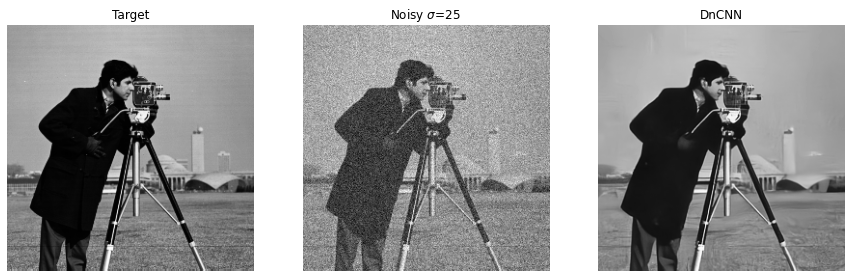

In [2]:
import imageio
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sigma = 25

def to_tf(x):
    return x[None,...,None]

def from_tf(x):
    return np.squeeze(x)

target = imageio.imread('./data/denoising/Set12/01.png').astype(np.float32)/255.0
noisy = target + np.random.normal(0, sigma/255.0, target.shape)
prediction = from_tf(model.predict(to_tf(noisy)))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(target, cmap='gray')
plt.title('Target')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(noisy, cmap='gray')
plt.title(f'Noisy $\sigma$={sigma}')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(prediction, cmap='gray')
plt.title(f'DnCNN')
plt.axis('off')

## Data Loading

In the following, we load the data for `subject1.h5`. The challenge will be evaluated on `subject2.h5`!

In [3]:
if not os.path.exists('./data/subject1.h5'):
    os.system('wget https://github.com/ISMRM-MIT-CMR/CMR-DL-challenge/raw/master/data/subject1.h5 -O ./data/subject1.h5')

if not os.path.exists('./data/subject2.h5'):
    os.system('wget https://github.com/ISMRM-MIT-CMR/CMR-DL-challenge/raw/master/data/subject2.h5 -O ./data/subject2.h5')


In [4]:
import h5py
subId = 2 # subject ID. For the challenge task, please set to 2.

with h5py.File(f'./data/subject{subId}.h5', 'r') as f:
  kspace = f['kspace'][()]
  csm = f['csm'][()]
  mask = f['mask_R4'][()]

print('Dimensions: ')
print('kspace: ', kspace.shape)
print('csm: ', csm.shape)
print('mask: ', mask.shape)

Dimensions: 
kspace:  (10, 176, 132)
csm:  (10, 176, 132)
mask:  (132,)


## Data Visualization and Evaluation

We provide basic evaluation and visualization tools here.

In [5]:
def center_crop(data, shape):
    """
    [source] https://github.com/facebookresearch/fastMRI/blob/master/data/transforms.py
    [source] https://github.com/khammernik/medutils/blob/master/medutils/visualization.py
    Apply a center crop to the input real image or batch of real images.
    Args:
        data (numpy.array): The input tensor to be center cropped. It should have at
            least 2 dimensions and the cropping is applied along the last two dimensions.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.
    Returns:
        numpy.array: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[-2]
    assert 0 < shape[1] <= data.shape[-1]
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to]

def process4display(x):
    """
        Helper function to compute the magnitude and crop the image to the central part, which will
        be evaluated.
    """
    return center_crop(np.abs(x), (100, 100))

In [6]:
def nrmse(x, x_ref):
    """
    Compute the Normalized Root Mean Squared Error
    Args:
        x (np.array): predicted image
        x_ref (np.array): target image
    Return:
        float: Computed metric
    """
    x = center_crop(x, (100, 100))
    x_ref = center_crop(x_ref, (100, 100))
    return np.sqrt(np.sum((np.abs(x_ref) - np.abs(x))**2) / np.sum(np.abs(x_ref)**2))

## MRI Reconstruction

In the following, we defined the forward and adjoint operators for Cartesian 2D MRI reconstruction.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define Cartesian Forward Operator
def forwardOp(x, csm, mask):
    def fft2c(x, axes=(-2,-1)):
      return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x, axes=axes), axes=axes, norm='ortho'), axes=axes)
    return fft2c(x * csm, axes=(1,2)) * mask
A = lambda x: forwardOp(x, csm, mask)

# Define Cartesian Adjoint Operator
def adjointOp(y, csm, mask):
    def ifft2c(y, axes=(-2,-1)):
      return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(y, axes=axes), axes=axes, norm='ortho'), axes=axes)
    return np.sum(ifft2c(y * mask, (1,2)) * np.conj(csm), 0)
AH = lambda y: adjointOp(y, csm, mask)

# Test adjointness
p = np.random.randn(*kspace.shape)
u = np.random.randn(*AH(kspace).shape)
lhs = np.sum(A(u) * np.conj(p))
rhs = np.sum(u * np.conj(AH(p)))
print(lhs, rhs)

# Store in operator class to be used in the Conjugate Gradient (CG) Optimizer
class MRIOperator():
    def forward(self, x):
        return A(x)
    def adjoint(self, x):
        return AH(x)

(21.874682341134328+91.91261304202611j) (21.874682341134367+91.91261304202612j)


Now, we can compute the undersampled image (zero filling), and the target image.
Please note that the target does not exist for `subject2.h5`!

inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


(-0.5, 99.5, 99.5, -0.5)

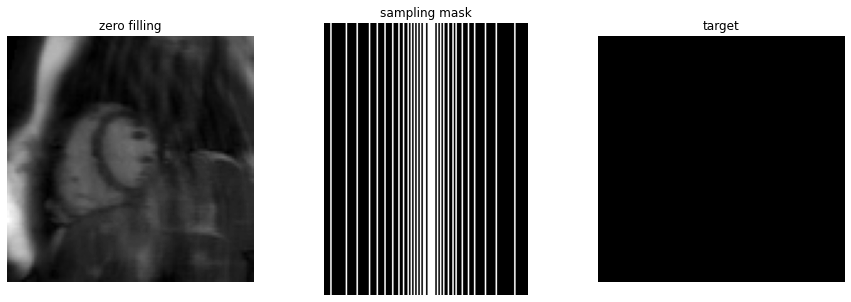

In [8]:
# Compute zero filling
zero_filling = AH(kspace * mask)

# Normalize data
norm = np.max(np.abs(zero_filling))
kspace /= norm

# Compute target
if subId == 1:
  target = adjointOp(kspace, csm, np.ones_like(mask))
else:
  target = np.zeros_like(zero_filling)

print(nrmse(zero_filling, target))
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(process4display(zero_filling), cmap='gray')
plt.title('zero filling')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(np.ones_like(np.abs(zero_filling))*mask, cmap='gray')
plt.title('sampling mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(process4display(target), cmap='gray')
plt.title('target')
plt.axis('off')

### Conjugate Gradient Optimization

Pruessmann, K. P.; Weiger, M.; Boernert, P. and Boesiger, P.
        [Advances in sensitivity encoding with arbitrary k-space trajectories.](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.1241?sid=nlm%3Apubmed)
        Magn Reson Med 46: 638-651 (2001)

In [9]:
# CG SENSE Reconstruction
class CgSenseReconstruction(object):
    """ CG Reconstruction using the algorithm in [1].
    [1] Pruessmann, K. P.; Weiger, M.; Boernert, P. and Boesiger, P.
        Advances in sensitivity encoding with arbitrary k-space trajectories.
        Magn Reson Med 46: 638-651 (2001)
    """
    def __init__(self, op, alpha=0, tol=1e-6, max_iter=50):
        """ Initialization
        :param op: operator class containing a forward and adjoint method
        :param alpha: Tikohonov regularization parameter
        :param tol: relative tolerance
        :param max_iter: maximum number of iterations
        """
        self._alpha = alpha
        self._tol = tol
        self._max_iter = max_iter
        self.op = op

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, value):
        self._alpha = value

    @property
    def tol(self):
        return self._tol

    @tol.setter
    def tol(self, value):
        self._tol = value

    @property
    def max_iter(self):
        return self._max_iter

    @max_iter.setter
    def max_iter(self, value):
        self._max_iter = value
        
    def complexDot(self, u, v):
        """ Compute complex dot product
        :param u: np.array
        :param v: np.array
        :return: complex dot product of u and v
        """
        return np.dot(np.conjugate(u.flatten()) , v.flatten())
    
    def normSquared(self, u):
        """ Compute squared norm
        :param u: np.array
        :return: squared norm of u
        """
        return np.real(np.dot(np.conjugate(u.flatten()) , u.flatten()))

    def __systemMatrix__(self, x):
        """ Compute result on system matrix A^H * A + alpha * I
        :param x: np.array
        :return: result for system matrix applied on x
        """
        return self.op.adjoint(self.op.forward(x)) + self.alpha*x
    
    def solve(self, rhs, return_series=False, return_tol=False, verbose=False):
        """ Compute solution
        :param y: input data (np.array)
        :param return_series: return the solutions for the individual iterations
        :param return_tol: return tol for the individual iterations
        :param verbose: boolean to turn on/off debug print
        :return: return specified values
        """
        x0 = np.zeros_like(rhs) + 1e-12 # a
        x = np.zeros_like(rhs) # b_approx^(0)
        r = rhs.copy()
        p = r.copy()
        rr = self.normSquared(r)
        x0x0 = self.normSquared(x0) #a^Ha
        it = 0
        
        recons = []
        delta = [rr/x0x0]
        
        while rr/x0x0 > self.tol and it < self.max_iter:
            q = self.__systemMatrix__(p) # q
            tmp = rr / self.complexDot(p, q) # helper var
            x += tmp*p.copy()
            r -= tmp*q.copy()
            p = r.copy() + (self.normSquared(r)/rr)*p.copy()
            rr = self.normSquared(r)
            if verbose:
                print(it+1, rr/x0x0, self.tol)
            it += 1
            recons.append(x.copy())
            delta.append(rr/x0x0)
        
        return x

In [10]:
def dataprox(x, alpha, y, x_ref=None, max_iter=20):
    op = MRIOperator()
    opt = CgSenseReconstruction(op, alpha, max_iter=max_iter)
    rhs = op.adjoint(y) + alpha * x.copy()
    x = opt.solve(rhs)
    if x_ref is not None:
        current_nrmse = nrmse(x, x_ref)
        print(f"NRMSE = {current_nrmse:.02f}")
    return x

Linear SENSE reconstruction

1.5025535959349645 0.0


(-0.5, 99.5, 99.5, -0.5)

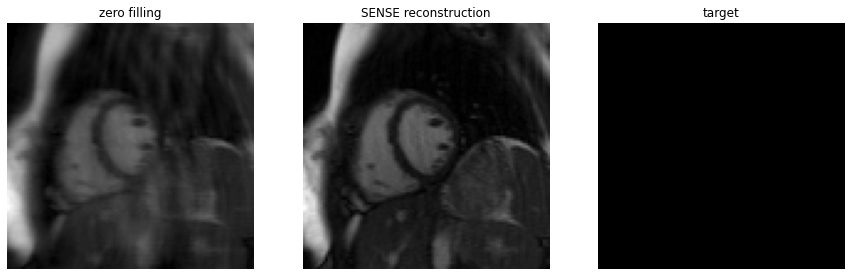

In [11]:
sense = dataprox(AH(kspace), 0, kspace, max_iter=10)
if not subId == 2:
  print(f'nrmse={nrmse(sense, target):.4g}')
print(np.max(np.abs(sense)), np.max(np.abs(target)))
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(process4display(zero_filling), cmap='gray')
plt.title('zero filling')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(process4display(sense), cmap='gray')
plt.title('SENSE reconstruction')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(process4display(target), cmap='gray')
plt.title('target')
plt.axis('off')

## CHALLENGE: Denoiser



### Get Denoising model

TODO: Adjust `getModel`

We have provided a template here. You can adjust this template to use your favourite denoiser!

In [12]:
from tensorflow.keras.models import load_model, model_from_json

def getModel():
  #TODO: Adjust model and use your favourite denoiser!
  
  json_file = open('trained_models/dncnn.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights('./trained_models/dncnn.h5')
  #<end todo>

  print(model.summary())

  return model

model = getModel()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 640         input0[0][0]                     
__________________________________________________________________________________________________
relu2 (Activation)              (None, None, None, 6 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, None, None, 6 36864       relu2[0][0]                      
____________________________________________________________________________________________

### Define your denoiser

TODO: Write `denoiser` function.

TODO: Add helper functions if necessary.

Here, you are applying the selected denoising model `model` to your data. How can it be applied to complex valued numbers? Think also about proper normalization and un-normalization! Denoising models are usually trained for a fixed dynamic range.



In [13]:
def to_tf(x):
    return x[None,...,None]

def from_tf(x):
    return np.squeeze(x)

def denoiser(x, tau, x_ref=None):
    """
    Args:
      x (np.array): input to the denoiser
      tau (float): scalar applied before denoising as normalization, and after denoising as re-normalization.

    Sample model call for real numbers: from_tf(model.predict(to_tf(x_re * tau))) / tau
    """
    #TODO write your own denoiser here
    def norm(x):
        "Norm x between [0,1] and return normalization factors"
        min = np.min(x)
        max = np.max(x)
        return (x - min) / (max - min), min, max

    def unnorm(x, min, max):
        "Undo normalization based on provided min/max valuees"
        return x * (max - min) + min

    def apply(x):
        x, min, max = norm(x)
        x = from_tf(model.predict(to_tf(x * tau))) / tau
        return unnorm(x, min, max)

    return apply(np.real(x)) + 1j * apply(np.imag(x))
    #<end todo>

    if x_ref is not None:
        current_nrmse = nrmse(x, x_ref)
        print(f"NRMSE = {current_nrmse:.02f}")

    return x

## CHALLENGE: Optimizer

Here, you are going to write your optimizer! You can find inspirations in the provided literature.

TODO: Write `optimizer` function. You can adapt the function handle if you need more parameters.

In [14]:
def optimizer(y, alpha=1.0, tau=1.0, iter=10, cg_iter=10, x_ref=None):
  """
  Args:
    y (np.array): kspace
    alpha (float): regularization parameter
    tau (float): scaling parameter for denoiser to adapt input to trained noise level
    iter (int): Total number of iteration for the optimization
    cg_iter (int): Total number of iterations for the CG optimizer in the dataprox
    x_ref (None, np.array): If target is provided, you receive some debug output (nrmse)
  """

  #TODO choose your favourite optimizer!
  # This sample solution builds on:
  # Meinhardt et al. Learning Proximal Operators: Using Denoising
  # Networks for Regularizing Inverse Imaging Problems. In: IEEE   
  # International Conference on Computer Vision (ICCV), pp. 1799-1808, 2017.
  x_old = AH(y)
  v = AH(y)
  x_bar = AH(y)
  theta = 1.0

  for k in range(iter):
    # Prox (reg)
    v = v + x_bar - denoiser(v + x_bar, tau)
    # Prox (data)
    x_new = dataprox(x_old - v, alpha, y, max_iter=cg_iter)
    # Over-relaxation
    x_bar = x_new + theta * (x_new - x_old)
    # store new x_old
    x_old = x_new.copy()

    x_out = x_new.copy()
    #<end todo>

    if x_ref is not None:
        current_nrmse = nrmse(x_out, x_ref)
        print(f"NRMSE {k} = {current_nrmse:.02f}")
  return x_out


Now, let us run the optimization and check the final results! 

TODO: Adapt the parameters for your challenge solution!

(-0.5, 99.5, 99.5, -0.5)

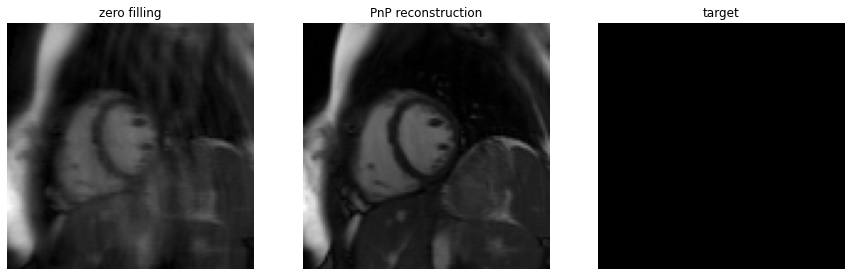

In [15]:
# TODO: adapt the parameters here for the function call. When submitting, be sure that these
# parameters are intended for `subject2.h5`.
pnp = optimizer(kspace.copy(), alpha=0.004, tau=1.2, iter=50, cg_iter=10)
# TODO: Please do not forget to fill out the Powerpoint template that we provided to present your
# results.
#<end todo>

if not subId == 2:
  print(f'nrmse={nrmse(pnp, target):.4g}')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(process4display(zero_filling), cmap='gray')
plt.title('zero filling')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(process4display(pnp), cmap='gray')
plt.title('PnP reconstruction')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(process4display(target), cmap='gray')
plt.title('target')
plt.axis('off')